# **SVD decomposition and applications**

SVD is a factorization used for solving linear equations, dimensionality reduction, data compression and so on.
It's based on the following decomposition:


𝐴=𝑈Σ𝑉∗
 

In which the matrix A (m x n) can be factorized into three matrices:


* U (m x m) unitary matrix 
* Σ (m x n) rectangular diagonal matrix 
* V (n x n) unitary matrix 



Columns of V are the eigenvectors of A*A called singular vectors

Columns of U are the eigenvectors of AA* called singular vectors

The elements on the diagonal of Σ are the ordered non-zero eigenvalues of both A*A and AA* called singular values

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
import sys
import matplotlib.animation as animation
from IPython.display import HTML

import cv2

In [ ]:
def svd(A, tol=1e-5):
    #singular values and right singular vectors coming from eigenvalues and eigenvectors of A' x A
    eigs, V = linalg.eig(A.T.dot(A))

    #singular values are the square root of the eigenvalues
    sing_vals = np.sqrt(eigs)

    #sort both sigular values and right singular vector
    idx = np.argsort(sing_vals)

    sing_vals = sing_vals[idx[::-1]]
    V = V[:, idx[::-1]]

    #remove zero singular values below tol
    sing_vals_trunc = sing_vals[sing_vals>tol]
    V = V[:, sing_vals>tol]

    #is not necessary to store the entire sigma matrix, so only the diagonal is returned
    sigma = sing_vals_trunc

    #evaluate U matrix
    U = A @ V /sing_vals_trunc
    
    return U.real, sigma.real, V.T.real

In [ ]:
def truncate(U, S, V, k):
    U_trunc = U[:, :k]
    S_trunc = S[:k]
    V_trunc = V[:k, :]
    return U_trunc, S_trunc, V_trunc

In [ ]:
from sklearn.datasets import load_iris
import seaborn as sns
import pandas as pd

iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [ ]:
data = pd.DataFrame(iris.data)
feature_names = iris["feature_names"]
data.columns = feature_names
data["labels"] = iris.target

In [ ]:
def custom_pairplot(data, feature_names, labels):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(left = 0, right=1.5, bottom=0, top=1.5)
    n_features = len(feature_names)
    
    for i in range(len(feature_names)):
        for j in range(len(feature_names)):
            plt.subplot(n_features, n_features, i*n_features+j+1)
            if i==j:
                sns.violinplot(data=data, x=labels, y=feature_names[i])
            else:
                plt.scatter(data[feature_names[i]], data[feature_names[j]], c=data[labels])
                plt.xlabel(feature_names[i])
                plt.ylabel(feature_names[j])

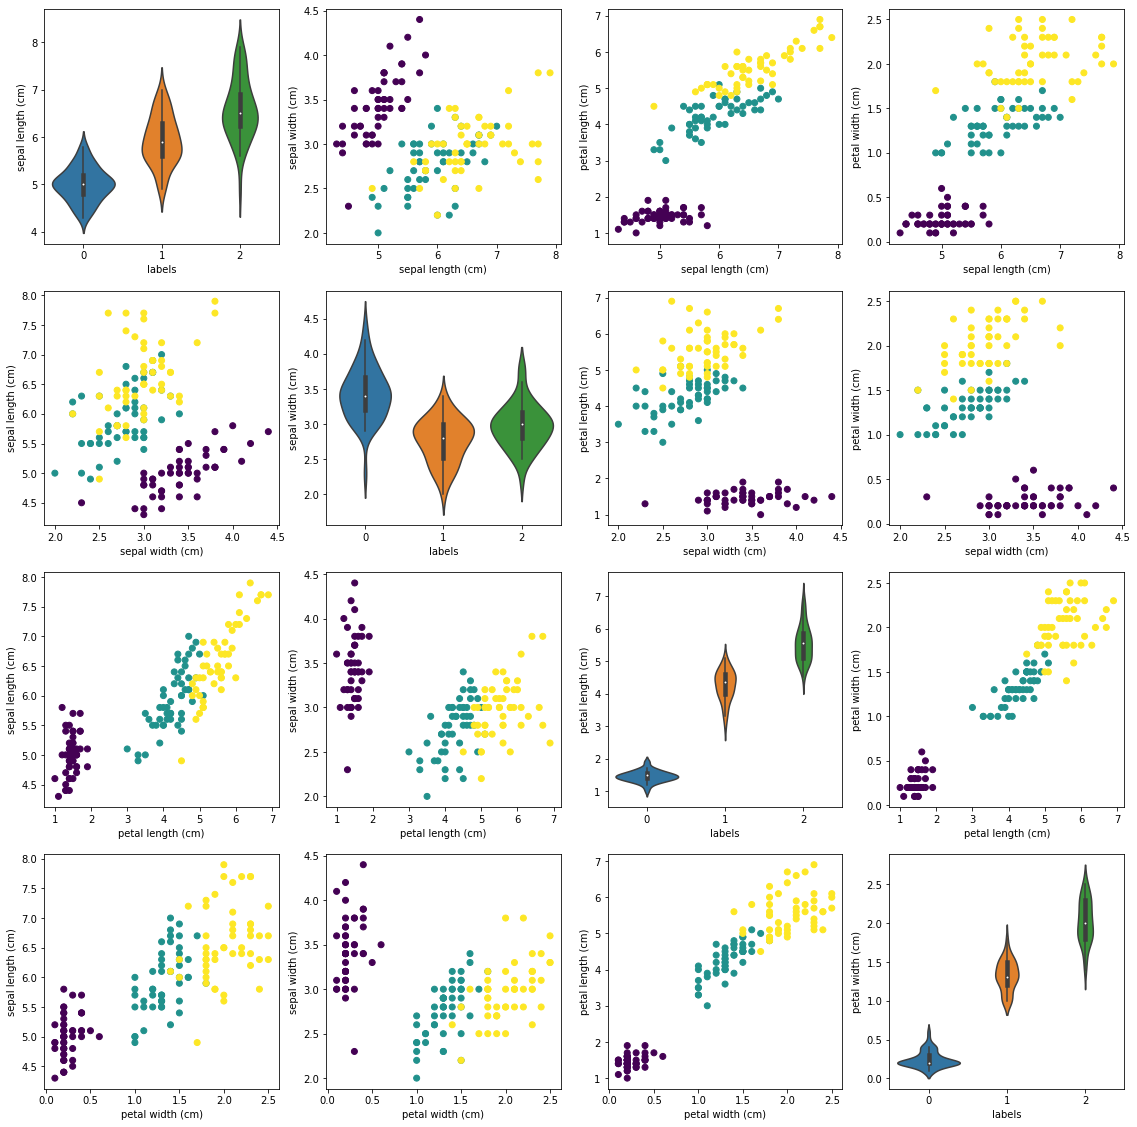

In [ ]:
custom_pairplot(data, feature_names=feature_names, labels="labels")

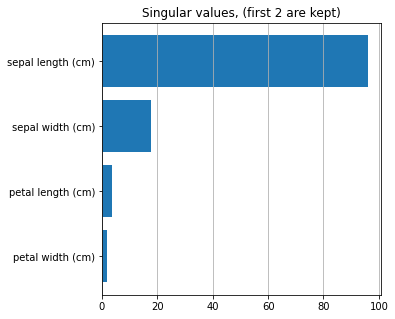

In [ ]:
k = 2

A = data[feature_names].values

U, S, Vt = svd(A)
U_trunc, S_trunc, Vt_trunc = truncate(U, S, Vt, k)

trunc_A = U_trunc @ np.diag(S_trunc)
reduced_data = pd.DataFrame(trunc_A)
plt.figure(figsize=(5, 5))
plt.barh(feature_names[::-1], S[::-1])
plt.title(f"Singular values, (first {k} are kept)")
plt.gca().xaxis.grid(True)

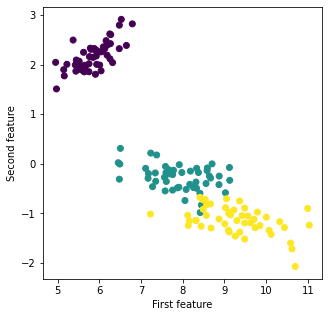

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(reduced_data[0], reduced_data[1], c = iris.target)
plt.xlabel("First feature")
plt.ylabel("Second feature");

## **SVD for Image Compression**

In [ ]:
def im2double(im):
    info = np.iinfo(im.dtype)
    return im.astype(np.float)/info.max

In [ ]:
# grayscale image (is still saved with 3 channels so I take the first one)
img = plt.imread("/content/drive/MyDrive/Dataset/807716.jpg")[:,:,0]

In [ ]:
gray_channel = im2double(img)

#my implementation
U, S, V = svd(gray_channel)

#linalg library implementation
U_, S_, V_ = np.linalg.svd(gray_channel)

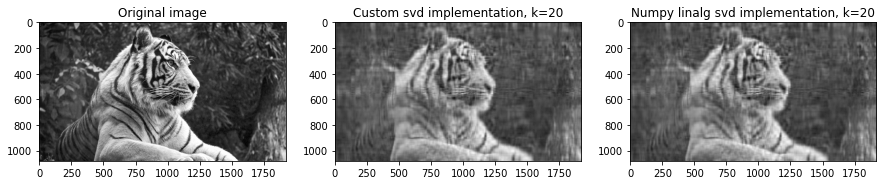

In [ ]:
#number of singular values kept
k = 20

fig = plt.figure(figsize=(15,15))

ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

plt.ion()

fig.canvas.draw()

U_trunc, S_trunc, Vt_trunc = truncate(U, S, V, k)
_U_trunc, _S_trunc, _Vt_trunc = truncate(U_, S_, V_, k)

my_channel = 255 * U_trunc @ np.diag(S_trunc) @ Vt_trunc
linalg_channel = 255 * _U_trunc @ np.diag(_S_trunc) @ _Vt_trunc

ax1.title.set_text(f"Original image")
ax1.imshow(gray_channel, cmap='gray')
    
ax2.title.set_text(f"Custom svd implementation, k={k}")
ax2.imshow(my_channel, cmap='gray')


ax3.title.set_text(f"Numpy linalg svd implementation, k={k}")
ax3.imshow(linalg_channel, cmap='gray')

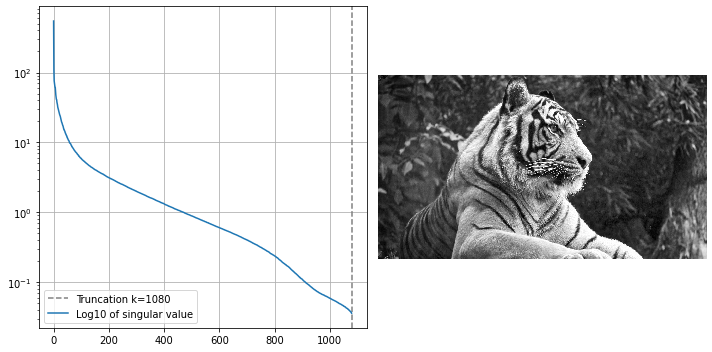

In [ ]:
plt.rcParams['animation.embed_limit'] = 2**128
fps = 30
step = 5

fig, (ax1, ax2) = plt.subplots(1, 2)

ax2.axis("off")

#set figure dimension
fig.set_size_inches(10, 5)

#set first frame for the first plot (single values)
ax1.set_yscale("log")
ax1.plot(S)
ax1.grid()


#set first frame for the second plot (image)
im = ax2.imshow(gray_channel, interpolation='none', vmin=0, vmax=1, cmap='gray');
plt.tight_layout()

def animate_func(i):
    #set next frame for single value truncation
    k = len(S)-i*step
    ax1.clear()
    ax1.set_yscale("log")
    ax1.axvline(x=k, ymin=0, ymax=1, c="gray", linestyle="--")
    ax1.plot(S)
    ax1.legend([f"Truncation k={k}", "Log10 of singular value"])
    
    ax1.grid()
        
    #truncate svd decomposition and set new frame
    U_trunc, S_trunc, Vt_trunc = truncate(U, S, V, k)
    new_channel = U_trunc @ np.diag(S_trunc) @ Vt_trunc
    im.set_array(new_channel)
    return [fig]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(S)//step+1,
                               interval = 100 / fps, # in ms
                               );